


 => Market1501 loaded

--------------------------------------
  subset  |  ids | images | relabeled
--------------------------------------
  train   |  751 |   12936|   True  
  query   |  750 |    3368|   False 
  gallery |  751 |   19732|   False 
--------------------------------------
  total   | 2252 |   36036|     - 
--------------------------------------






 => Market1501 loaded

--------------------------------------
  subset  |  ids | images | relabeled
--------------------------------------
  train   |  751 |   12936|   True  
  query   |  750 |    3368|   False 
  gallery |  751 |   19732|   False 
--------------------------------------
  total   | 2252 |   36036|     - 
--------------------------------------





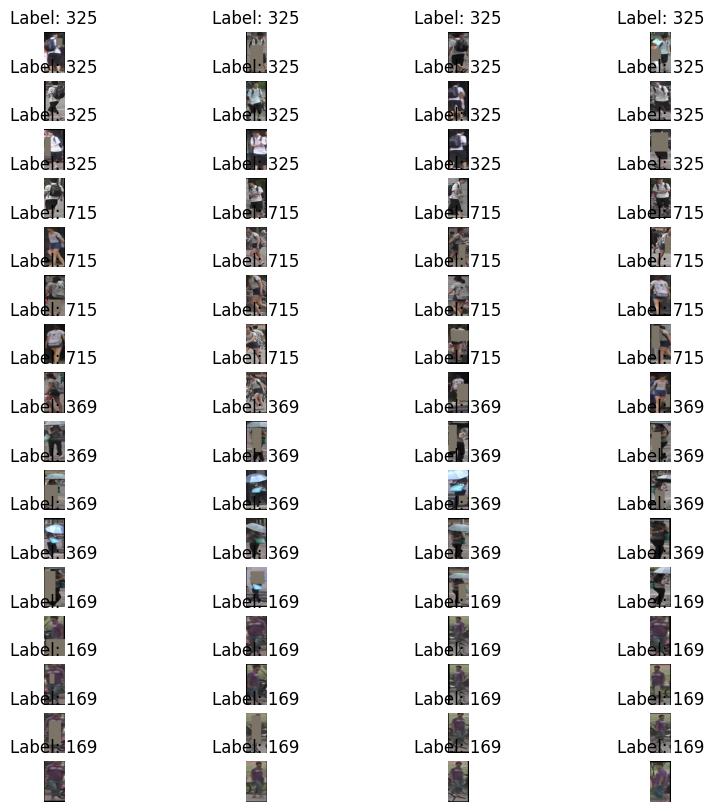

In [1]:



import torch
import torchvision
from IPython import embed
from data_manager import Market1501
from dataset import ImageDataset
from torchvision import transforms as T
from torch.utils.data import DataLoader
from model import ReID
from tqdm import tqdm
from torch import nn
import numpy as np
from loss import TripletHardLoss
from samplers import   RandomIdentitySampler

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning import samplers
from loss import LabelSmoothingLoss, CenterLoss

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark=True



from torch.utils.data.sampler import Sampler
import random
from collections import defaultdict




import math
import random

class RandomErasing(object):
    """ Randomly selects a rectangle region in an image and erases its pixels.
        'Random Erasing Data Augmentation' by Zhong et al.
        See https://arxiv.org/pdf/1708.04896.pdf
    Args:
         probability: The probability that the Random Erasing operation will be performed.
         sl: Minimum proportion of erased area against input image.
         sh: Maximum proportion of erased area against input image.
         r1: Minimum aspect ratio of erased area.
         mean: Erasing value.
    """

    def __init__(self, probability=0.5, sl=0.02, sh=0.4, r1=0.3, mean=(0.4914, 0.4822, 0.4465)):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img):

        if random.uniform(0, 1) >= self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]

            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1 / self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                    img[1, x1:x1 + h, y1:y1 + w] = self.mean[1]
                    img[2, x1:x1 + h, y1:y1 + w] = self.mean[2]
                else:
                    img[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                return img

        return img




width = 128
height = 256
max_epochs = 300
transform_train = T.Compose([
    T.Resize([256,128]),
    T.Pad(10),
    T.RandomCrop([height,width]),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    RandomErasing(probability=0.5,mean=[0.485,0.456,0.406])
])


transform_test = T.Compose([
    T.Resize([height, width]),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

data = Market1501()

train_dataset = ImageDataset(data.train, transform=transform_train)
query_dataset = ImageDataset(data.query, transform=transform_test)
gallery_dataset = ImageDataset(data.gallery, transform=transform_test)

query_loader = DataLoader(query_dataset, batch_size=16, shuffle=False,num_workers=8)
gallery_loader = DataLoader(gallery_dataset, batch_size=16, shuffle=False,num_workers=8)

# PK sampling
P = 16
K = 4
train_dataset = ImageDataset(data.train,transform=transform_train)
sampler = RandomIdentitySampler(data.train, num_instances=K)
train_loader = DataLoader(train_dataset, batch_size=P*K, sampler=sampler, num_workers=8)


def main():



    # criterion = nn.CrossEntropyLoss()
    criterion = LabelSmoothingLoss(data.train_num_pids, 0.1)
    triplet_loss = losses.TripletMarginLoss(margin=0.3)
    center_loss = CenterLoss(data.train_num_imgs, 2048, 'cuda:0')
    center_loss_weight = 0.001
    # 优化器

    model = ReID(num_classes=data.train_num_pids)
    # criterion = TripletHardLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00035)
    device = 'cuda:0'
    model = model.to(device)
    # test(model,query_loader,gallery_loader,True,[1,3,5,10,20])
    # evaluate(model,device)
    train(model,criterion,triplet_loss,center_loss,center_loss_weight,optimizer,max_epochs,device,evaluate_on_n_epochs=10)
    # embed()
    pass



def train(model,criterion, triplet_loss, center_loss,center_loss_weight , optimizer, max_epochs,device = 'cuda:0', evaluate_on_n_epochs=5):

    for epoch in range(max_epochs):
        model.train()
        epoch += 1
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")
        total_loss = 0.0
        total_id_loss = 0.0
        total_tri_loss = 0.0
        total_ct_loss = 0.0
        total_running_correct_samples = 0
        total_samples = 0
        for i,data in pbar:
            imgs,pids,camids = data
            imgs = imgs.to(device)
            pids = pids.to(device)
            outputs,features = model(imgs)

            id_loss = criterion(outputs, pids)
            tri_loss = triplet_loss(features, pids)
            ct_loss = center_loss_weight * center_loss(features,pids)
            loss = id_loss + tri_loss + ct_loss


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs,1)  # 获取预测的样本号码
            
            total_running_correct_samples += (predicted == pids).sum().item()
            total_samples += pids.shape[0]
            total_loss += loss.item()
            total_id_loss += id_loss.item()
            total_tri_loss += tri_loss.item()
            total_ct_loss += ct_loss.item()

            pbar.set_postfix({
                              'acc': total_running_correct_samples/total_samples,
                              'id_loss': total_id_loss/(i+1),
                              'tri_loss':total_tri_loss/(i+1),
                              'ct_loss': total_ct_loss/(i+1),
                              'loss' : total_loss/(i+1),
                              })
        if epoch % evaluate_on_n_epochs == 0:
            # evaluate(model,device)
            test(model,query_loader,gallery_loader,True,[1,3,5,10,20])




def extract_features(model, loader, device):
    model.eval()
    features = torch.FloatTensor()
    pids = []
    camids = []
    with torch.no_grad():
        for data in tqdm(loader,'Extracting features:'):
            images, pid, camid = data
            images = images.to(device)
            outputs = model(images)
            features = torch.cat((features, outputs.cpu()), 0)
            pids.extend(pid)
            camids.extend(camid)
    return features, np.array(pids), np.array(camids)

def compute_dist_matrix(a, b):
    m, n = a.shape[0], b.shape[0]
    dist_matrix = torch.pow(a, 2).sum(dim=1, keepdim=True).expand(m, n) + \
                  torch.pow(b, 2).sum(dim=1, keepdim=True).expand(n, m).t()
    dist_matrix.addmm_(1, -2, a, b.t())
    return dist_matrix.cpu().numpy()

def evaluate_rank_map(distmat, q_pids, g_pids, q_camids, g_camids, max_rank=20):
    num_q, num_g = distmat.shape
    if num_g < max_rank:
        max_rank = num_g
        logger.info("Note: number of gallery samples is quite small, got {}".format(num_g))
    indices = np.argsort(distmat, axis=1)
    matches = (g_pids[indices] == q_pids[:, np.newaxis]).astype(np.int32)

    # Exclude same id and same camera
    all_cams = g_camids[indices] == q_camids[:, np.newaxis]
    all_pids = g_pids[indices] == q_pids[:, np.newaxis]
    valid = ~(all_cams & all_pids)
    matches = matches * valid

    # Compute CMC
    cmc = matches.cumsum(axis=1) > 0
    cmc = cmc.astype(np.float32).sum(axis=0) / num_q
    cmc = cmc[:max_rank]

    # Compute mAP
    num_rel = matches.sum(axis=1)
    tmp_cmc = matches.cumsum(axis=1) * matches
    tmp_cmc = [x / (np.arange(len(x)) + 1) for x in tmp_cmc]
    tmp_cmc = np.asarray([x.sum() / (num_rel[i] + 1e-12) for i, x in enumerate(tmp_cmc)])
    mAP = tmp_cmc.sum() / num_q

    return cmc, mAP

def evaluate(model, device):
    qf, q_pids, q_camids = extract_features(model, query_loader, device)
    gf, g_pids, g_camids = extract_features(model, gallery_loader, device)
    distmat = compute_dist_matrix(qf, gf)
    cmc, mAP = evaluate_rank_map(distmat, q_pids, g_pids, q_camids, g_camids)
    logger.info("Results:")
    logger.info("mAP: {:.1%}".format(mAP))
    for r in [1, 3, 5, 10, 20]:
        logger.info("Rank-{:<3}: {:.1%}".format(r, cmc[r-1]))
    return cmc, mAP






def evaluate_t(distmat, q_pids, g_pids, q_camids, g_camids, max_rank):
    """Evaluation with market1501 metric
    Key: for each query identity, its gallery images from the same camera view are discarded.
    """
    num_q, num_g = distmat.shape
    if num_g < max_rank:
        max_rank = num_g
        logger.info("Note: number of gallery samples is quite small, got {}".format(num_g))
    indices = np.argsort(distmat, axis=1)
    matches = (g_pids[indices] == q_pids[:, np.newaxis]).astype(np.int32)

    # compute cmc curve for each query
    all_cmc = []
    all_AP = []
    num_valid_q = 0. # number of valid query
    for q_idx in tqdm(range(num_q),'Evaluating:'):
        # get query pid and camid
        q_pid = q_pids[q_idx]
        q_camid = q_camids[q_idx]

        # remove gallery samples that have the same pid and camid with query
        order = indices[q_idx]
        remove = (g_pids[order] == q_pid) & (g_camids[order] == q_camid)
        keep = np.invert(remove)

        # compute cmc curve
        orig_cmc = matches[q_idx][keep] # binary vector, positions with value 1 are correct matches
        if not np.any(orig_cmc):
            # this condition is true when query identity does not appear in gallery
            continue

        cmc = orig_cmc.cumsum()
        cmc[cmc > 1] = 1

        all_cmc.append(cmc[:max_rank])
        num_valid_q += 1.

        # compute average precision
        # reference: https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision
        num_rel = orig_cmc.sum()
        tmp_cmc = orig_cmc.cumsum()
        tmp_cmc = [x / (i+1.) for i, x in enumerate(tmp_cmc)]
        tmp_cmc = np.asarray(tmp_cmc) * orig_cmc
        AP = tmp_cmc.sum() / num_rel
        all_AP.append(AP)
    all_cmc = np.asarray(all_cmc).astype(np.float32)
    all_cmc = all_cmc.sum(0) / num_valid_q
    mAP = np.mean(all_AP)
    return all_cmc, mAP



def test(model, queryloader, galleryloader, use_gpu, ranks=[1, 5, 10, 20]):
    model.eval()

    with torch.no_grad():
        qf, q_pids, q_camids= [], [], []
        for batch_idx, (imgs, pids, camids) in enumerate(queryloader):
            if use_gpu: imgs = imgs.cuda()

            
            features = model(imgs)

            features = features.data.cpu()
            
            qf.append(features)
            
            q_pids.extend(pids)
            q_camids.extend(camids)
        qf = torch.cat(qf, 0)
        q_pids = np.asarray(q_pids)
        q_camids = np.asarray(q_camids)

        # logger.info("Extracted features for query set, obtained {}-by-{} matrix".format(qf.size(0), qf.size(1)))

        gf, g_pids, g_camids = [], [], []

        for batch_idx, (imgs, pids, camids) in enumerate(galleryloader):
            if use_gpu: imgs = imgs.cuda()


            features = model(imgs)


            features = features.data.cpu()

            gf.append(features)

            g_pids.extend(pids)
            g_camids.extend(camids)
        gf = torch.cat(gf, 0)

        g_pids = np.asarray(g_pids)
        g_camids = np.asarray(g_camids)


        # logger.info("Extracted features for gallery set, obtained {}-by-{} matrix".format(gf.size(0), gf.size(1)))


    # feature normlization
    qf = 1. * qf / (torch.norm(qf, 2, dim = -1, keepdim=True).expand_as(qf) + 1e-12)
    gf = 1. * gf / (torch.norm(gf, 2, dim = -1, keepdim=True).expand_as(gf) + 1e-12)
    m, n = qf.size(0), gf.size(0)
    distmat = torch.pow(qf, 2).sum(dim=1, keepdim=True).expand(m, n) + \
              torch.pow(gf, 2).sum(dim=1, keepdim=True).expand(n, m).t()
    distmat.addmm_(qf, gf.t(), beta=1, alpha=-2 )
    distmat = distmat.numpy()
    

    cmc,mAP= evaluate_t(distmat, q_pids, g_pids, q_camids, g_camids, 20)

    logger.info("Results ----------")
    logger.info("mAP: {:.1%}".format(mAP))
    logger.info("CMC curve")
    for r in ranks:
        logger.info("Rank-{:<3}: {:.1%}".format(r, cmc[r - 1]))
    logger.info("------------------")
    return cmc[0]


if __name__=='__main__':


    # main()
    # quit()
    from samplers import   RandomIdentitySampler
    from dataset import read_image
    import torchvision.transforms.functional as F
    def imshow(inp, title=None):
        """Imshow for Tensor."""

        plt.imshow(inp)
        if title is not None:
            plt.title(title)
    dataset = Market1501()

    # 使用RandomIdentitySampler
    train_dataset = ImageDataset(dataset.train,transform=transform_train)
    sampler = RandomIdentitySampler(dataset.train, num_instances=P)
    train_loader = DataLoader(train_dataset, batch_size=P*K, sampler=sampler, num_workers=0)

    import matplotlib.pyplot as plt

    # 获取一个批次的数据
    data_iter = iter(train_loader)
    images, labels, _ = next(data_iter)

    # embed()
    # 打印批次中的几张图片
    # 假设每行打印4张图片
    # 打印批次中的几张图片
    plt.figure(figsize=(10, 10))
    for i in range(P*K):
        ax = plt.subplot(P, K, i + 1)
        img = images[i]
        # 反归一化处理
        img = F.to_pil_image(img)
        plt.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

In [22]:
# 假设的权重
w = [3.0,7.0,13.0]
# 假设的目标热力图和模型输出热力图
y = [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]]
x = [[0.15, 0.25, 0.35], [0.45, 0.55, 0.65], [0.75, 0.85, 0.95]]
n = len(y)
m = len(y[0])
# 计算MSE
mse = [(sum([(x[i][j] - y[i][j])**2 for j in range(m)]) / m) for i in range(n)]

# 计算加权损失
weighted_loss = sum([wi*mse_i for wi, mse_i in zip(w, mse)])

weighted_loss

0.05749999999999997

In [24]:
from torchvision import transforms
data_transform = {
    "train": transforms.Compose([
        transforms.HalfBody(0.3, person_kps_info["upper_body_ids"], person_kps_info["lower_body_ids"]),
        transforms.AffineTransform(scale=(0.65, 1.35), rotation=(-45, 45), fixed_size=fixed_size),
        transforms.RandomHorizontalFlip(0.5, person_kps_info["flip_pairs"]),
        transforms.KeypointToHeatMap(heatmap_hw=heatmap_hw, gaussian_sigma=2, keypoints_weights=kps_weights,
                                        combine_keypoints=args.combine_keypoints,
                                        combined_keypoint_indexes = combined_keypoint_indexes),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=fixed_size),
        transforms.KeypointToHeatMap(heatmap_hw=heatmap_hw, gaussian_sigma=2, keypoints_weights=kps_weights,
                                        combine_keypoints=args.combine_keypoints,
                                        combined_keypoint_indexes = combined_keypoint_indexes),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

0.13249999999999998

In [ ]:
import torch